## Dataset: Lung and Colon Cancer Histopathological Images
## Link:- https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

## 1. Imports

In [174]:
import os
import torch
import numpy as np
import shutil

from torchvision import transforms 
from torchvision import models 
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision.models import vgg16
import torch.nn as nn
from collections import OrderedDict
from torch import optim

import matplotlib.pyplot as plt
import time

from os import listdir
from PIL import Image
import numpy as np

import random

## 2. Creating dataset directory tree

In [10]:
mkdir dataset

In [11]:
cd dataset

/kaggle/working/dataset


In [12]:
mkdir train validation test

In [13]:
cd train

/kaggle/working/dataset/train


In [14]:
mkdir colon_aca colon_n

In [15]:
cd ..

/kaggle/working/dataset


In [16]:
cd validation

/kaggle/working/dataset/validation


In [17]:
mkdir colon_aca colon_n

In [18]:
cd ..

/kaggle/working/dataset


In [19]:
cd test

/kaggle/working/dataset/test


In [20]:
mkdir colon_aca colon_n

In [21]:
cd ..

/kaggle/working/dataset


In [22]:
cd ..

/kaggle/working


In [23]:
#printing the directory tree

path = "./dataset"
for dirpath, dirnames, filenames in os.walk(path):
    directory_level = dirpath.replace(path, "")
    directory_level = directory_level.count(os.sep)
    indent = " " * 4
    print("{}{}/".format(indent*directory_level, os.path.basename(dirpath)))

    for f in filenames:
        print("{}{}".format(indent*(directory_level+1), f))

dataset/
    train/
        colon_aca/
        colon_n/
    test/
        colon_aca/
        colon_n/
    validation/
        colon_aca/
        colon_n/


## 3. Splitting the image set

In [24]:
cd ..

/kaggle


In [25]:
# I have tried to split the given imageset in 80:10:10 ratio for training, validation and testing datasets
# So for each class(5000 images), we should have approx 4000 for training and 500 each for validation and testing

origin = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca/'

for root, dirs, files in os.walk(origin):
    for file in files:
        random_number = np.random.randint(99) + 1
        if random_number <= 80:
            shutil.copy(origin+file, '/kaggle/working/dataset/train/colon_aca/'+file)
        elif random_number <=90:
            shutil.copy(origin+file, '/kaggle/working/dataset/validation/colon_aca/'+file)
        else:
            shutil.copy(origin+file, '/kaggle/working/dataset/test/colon_aca/'+file)

In [26]:
origin = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_n/'

for root, dirs, files in os.walk(origin):
    for file in files:
        random_number = np.random.randint(99) + 1
        if random_number <= 80:
            shutil.copy(origin+file, '/kaggle/working/dataset/train/colon_n/'+file)
        elif random_number <=90:
            shutil.copy(origin+file, '/kaggle/working/dataset/validation/colon_n/'+file)
        else:
            shutil.copy(origin+file, '/kaggle/working/dataset/test/colon_n/'+file)

In [27]:
# Checking the total number of files


for root, dirs, files in os.walk('/kaggle/working/dataset'):
    if files != []:
        print(root, "-->", len(files))

/kaggle/working/dataset/train/colon_aca --> 4027
/kaggle/working/dataset/train/colon_n --> 4041
/kaggle/working/dataset/test/colon_aca --> 459
/kaggle/working/dataset/test/colon_n --> 471
/kaggle/working/dataset/validation/colon_aca --> 514
/kaggle/working/dataset/validation/colon_n --> 488


## 4. Applying transforms and loading the data

In [144]:
data_dir = '/kaggle/working/dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [145]:
# Defining transforms for the training, validation, and testing sets
data_transforms_train = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(768),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ]
)

data_transforms_test_validate = transforms.Compose(
    [
        transforms.Resize(768),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ]
)


# Load the datasets with ImageFolder
image_datasets_train = datasets.ImageFolder(train_dir, transform = data_transforms_train)
image_datasets_validate = datasets.ImageFolder(valid_dir, transform = data_transforms_test_validate)
image_datasets_test = datasets.ImageFolder(test_dir, transform = data_transforms_test_validate)


# Using the image datasets and the transforms to define the dataloaders
dataloaders_train = DataLoader(image_datasets_train, batch_size = 64, shuffle = True)
dataloaders_validate = DataLoader(image_datasets_validate, batch_size = 64, shuffle = True)
dataloaders_test = DataLoader(image_datasets_test, batch_size = 64, shuffle = True)

In [146]:
# Checking the number of images in the datasets
# For total 10K images, we should have approx 80% or 8K for training and 10% or 1K each for testing and validation


print("Number of images :")
print("Training Dataset:", len(dataloaders_train.dataset))
print("Validation Dataset:", len(dataloaders_validate.dataset))
print("Test Dataset:", len(dataloaders_test.dataset))
print("____________________________")
print("Total = ", len(dataloaders_train.dataset) + len(dataloaders_validate.dataset) + len(dataloaders_test.dataset))

Number of images :
Training Dataset: 8068
Validation Dataset: 1002
Test Dataset: 930
____________________________
Total =  10000


In [147]:
print(dataloaders_train.dataset.class_to_idx)

{'colon_aca': 0, 'colon_n': 1}


## 5. Building and Training the classifier

In [148]:
# Using Vgg16


def pre_trained_model():
    base_model = vgg16(pretrained = True)
    for parameter in base_model.features:
        parameter.requires_grad = False
    
    #Replacing the classifier while features remain frozen
    base_model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 128)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(128, 2)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
                          
    base_model = base_model.to('cuda')
    return base_model 
    

base_model = pre_trained_model()
print(base_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [149]:
def funct_criterion():
    criterion = nn.NLLLoss()
    return criterion

In [150]:
def funct_optimizer(my_model, alpha = 0.001):
    optimizer = optim.Adam(my_model.classifier.parameters(), alpha)
    return optimizer

In [151]:
base_model = pre_trained_model()
criterion = funct_criterion()
optimizer = funct_optimizer(base_model, alpha = 0.001)

In [152]:
def check_accuracy(dataloaders):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders:
            images, labels = data[0].to('cuda'), data[1].to('cuda')
            outputs = base_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

TRAINING STARTED!!!!
Iteration --> 1/3 
		
Loss :  0.1076	Validation Accuracy :  0.513
		
Loss :  0.1218	Validation Accuracy :  0.498
		
Loss :  0.1238	Validation Accuracy :  0.8124
		
Loss :  0.0817	Validation Accuracy :  0.8413
		
Loss :  0.0909	Validation Accuracy :  0.8313
		
Loss :  0.092	Validation Accuracy :  0.8453
		
Loss :  0.0472	Validation Accuracy :  0.8144
		
Loss :  0.0447	Validation Accuracy :  0.8852
		
Loss :  0.031	Validation Accuracy :  0.8663
		
Loss :  0.0576	Validation Accuracy :  0.8533
		
Loss :  0.0442	Validation Accuracy :  0.8523
		
Loss :  0.0338	Validation Accuracy :  0.9042
		
Loss :  0.0517	Validation Accuracy :  0.8573
		
Loss :  0.035	Validation Accuracy :  0.8972
		
Loss :  0.0425	Validation Accuracy :  0.9002
		
Loss :  0.03	Validation Accuracy :  0.9202
		
Loss :  0.038	Validation Accuracy :  0.9152
		
Loss :  0.0334	Validation Accuracy :  0.9242
		
Loss :  0.036	Validation Accuracy :  0.9232
		
Loss :  0.021	Validation Accuracy :  0.9052
		
Loss : 

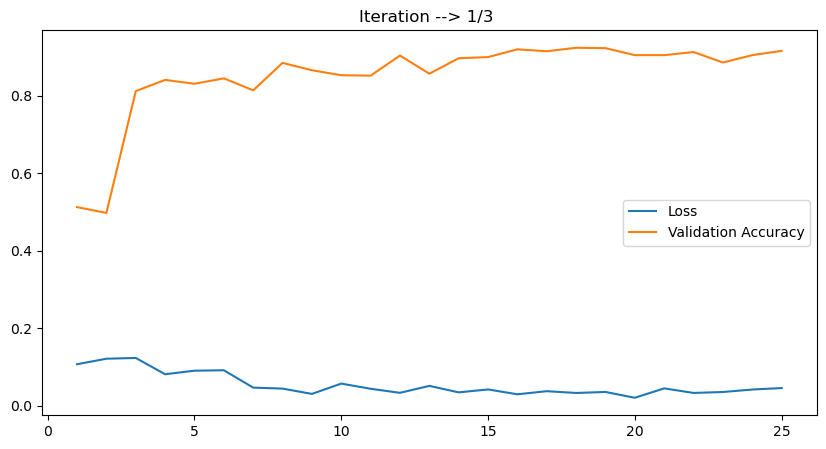

Iteration --> 2/3 
		
Loss :  0.0325	Validation Accuracy :  0.9361
		
Loss :  0.0188	Validation Accuracy :  0.9242
		
Loss :  0.0332	Validation Accuracy :  0.9361
		
Loss :  0.0299	Validation Accuracy :  0.9411
		
Loss :  0.0212	Validation Accuracy :  0.9471
		
Loss :  0.0098	Validation Accuracy :  0.9471
		
Loss :  0.0298	Validation Accuracy :  0.9301
		
Loss :  0.0393	Validation Accuracy :  0.9481
		
Loss :  0.0329	Validation Accuracy :  0.9082
		
Loss :  0.0303	Validation Accuracy :  0.9561
		
Loss :  0.0176	Validation Accuracy :  0.9381
		
Loss :  0.0254	Validation Accuracy :  0.9541
		
Loss :  0.0296	Validation Accuracy :  0.9501
		
Loss :  0.0171	Validation Accuracy :  0.9471
		
Loss :  0.0471	Validation Accuracy :  0.9531
		
Loss :  0.0328	Validation Accuracy :  0.9571
		
Loss :  0.0325	Validation Accuracy :  0.9541
		
Loss :  0.0342	Validation Accuracy :  0.9541
		
Loss :  0.0192	Validation Accuracy :  0.9471
		
Loss :  0.0382	Validation Accuracy :  0.9561
		
Loss :  0.0345	Val

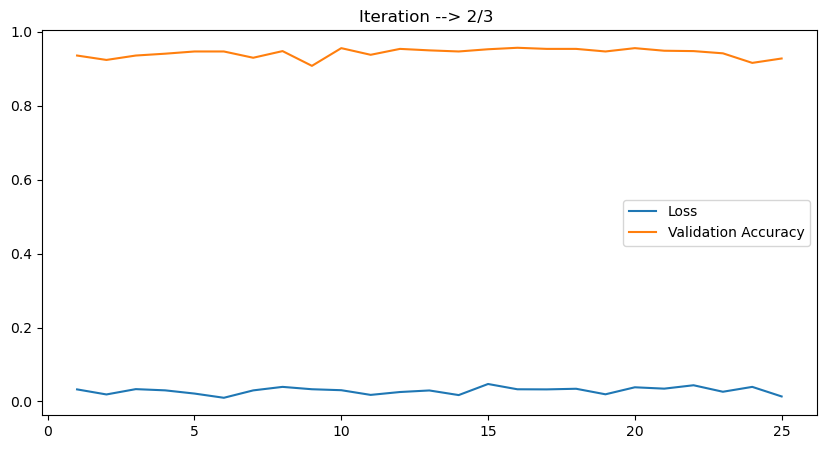

Iteration --> 3/3 
		
Loss :  0.0062	Validation Accuracy :  0.9501
		
Loss :  0.0209	Validation Accuracy :  0.9311
		
Loss :  0.0116	Validation Accuracy :  0.9541
		
Loss :  0.0125	Validation Accuracy :  0.9581
		
Loss :  0.0286	Validation Accuracy :  0.9641
		
Loss :  0.0173	Validation Accuracy :  0.9481
		
Loss :  0.0091	Validation Accuracy :  0.9631
		
Loss :  0.0412	Validation Accuracy :  0.9541
		
Loss :  0.0226	Validation Accuracy :  0.9491
		
Loss :  0.0302	Validation Accuracy :  0.9601
		
Loss :  0.0255	Validation Accuracy :  0.9551
		
Loss :  0.0155	Validation Accuracy :  0.9471
		
Loss :  0.0148	Validation Accuracy :  0.9391
		
Loss :  0.0183	Validation Accuracy :  0.9491
		
Loss :  0.0172	Validation Accuracy :  0.9691
		
Loss :  0.0293	Validation Accuracy :  0.9671
		
Loss :  0.0059	Validation Accuracy :  0.9681
		
Loss :  0.013	Validation Accuracy :  0.9721
		
Loss :  0.0274	Validation Accuracy :  0.9431
		
Loss :  0.0076	Validation Accuracy :  0.9571
		
Loss :  0.0496	Vali

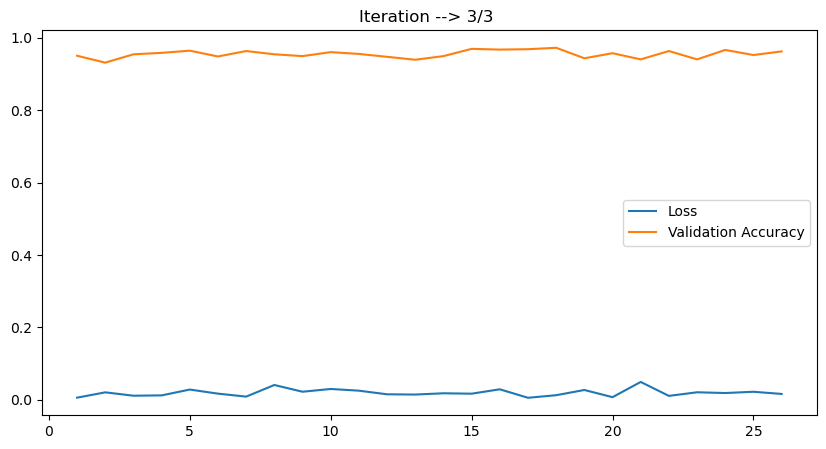

TRAINING OVER!!!!
Training Time:  14.423339597384135  minutes


In [153]:
print("TRAINING STARTED!!!!")
start = time.time()


num_of_iterations = 3
print_every = 5
steps = 0

for i in range(num_of_iterations):
    
    Loss = []
    Validation_accuracy = []
    count = []
    j = 1
    
    
    print("================================================================")
    print("Iteration --> {}/{} ".format(i+1, num_of_iterations), end = '\n')
    print("================================================================")
    
    for inputs, labels in dataloaders_train:
        
        running_loss = 0
        steps += 1
        
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        
        #Feeding forward
        outputs = base_model.forward(inputs)
        loss = criterion(outputs, labels)
        #Back-propagation
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
        
        with torch.no_grad():
            if steps % print_every == 0:
                validation_accuracy = check_accuracy(dataloaders_validate)
                print("\t\t")
                print("Loss : ", round((running_loss/print_every), 4), end = '\t')
                print("Validation Accuracy : ", round(validation_accuracy, 4))
                Loss.append(round((running_loss/print_every), 4))
                Validation_accuracy.append(round(validation_accuracy, 4))
                count.append(j)
                j += 1
    print()
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    plt.plot(count, Loss, label = "Loss")
    plt.plot(count, Validation_accuracy, label = "Validation Accuracy")
    plt.title("Iteration --> {}/{} ".format(i+1, num_of_iterations))
    plt.legend()
    plt.show()
    torch.cuda.empty_cache()

    
    
    
print("TRAINING OVER!!!!")
end = time.time()
print("Training Time: ", (end - start)/60, " minutes")

## 6. Testing the network

In [154]:
def test_accuracy(dataloaders):
    return check_accuracy(dataloaders)

ans = test_accuracy(dataloaders_test)
print("Network Accuracy on the Test Dataset = ", round(ans*100, 4), "%")

Network Accuracy on the Test Dataset =  95.8065 %


## 7. Save the checkpoint

In [245]:
# Saving the checkpoint 

base_model.class_to_idx = image_datasets_train.class_to_idx
#print(base_model.class_to_idx)

dictionary = {
            'transfer model': 'vgg16',
            'input_size': 25088,
            'output_size': 5,
            'features': base_model.features,
            'classifier': base_model.classifier,
            'optimizer': optimizer.state_dict(),
            'state_dict': base_model.state_dict(),
            #'idx_to_class': {v:k for k, v in image_datasets_train.class_to_idx.items()}
            'class_to_idx' : base_model.class_to_idx
            }
torch.save(dictionary, 'checkpoint.pth')

## 8. Loading the checkpoint

In [247]:
def load_checkpoint(checkpoint_path):
    base_model_info = torch.load(checkpoint_path)
    base_model = vgg16(pretrained = True)
    
    base_model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 128)),
                          ('relu', nn.ReLU()),
                          ('fc3', nn.Linear(128, 2)),
                          ('output', nn.LogSoftmax(dim = 1))
                          ]))
    
    
    base_model.load_state_dict(base_model_info['state_dict'])
    #idx_to_class = base_model_info['idx_to_class']
    #return base_model, base_model_info, idx_to_class
    class_to_idx = base_model_info['class_to_idx']
    return base_model, base_model_info, class_to_idx

base_model, base_model_info, class_to_idx = load_checkpoint('checkpoint.pth')
print(base_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [248]:
print(class_to_idx)

{'colon_aca': 0, 'colon_n': 1}


## 9. Inference for classification

In [187]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Processing a PIL image for use in a PyTorch model
        
    image = Image.open(image_path)
    image.load()
    
    """
    # Resizing the image
    
    coordinates = list(image.size)
    short_side = min(coordinates)
    short_side_index = coordinates.index(short_side)
    if short_side_index == 0:
        long_side_index = 1
    else:
        long_side_index = 0
    aspect_ratio = coordinates[long_side_index] / coordinates[short_side_index]
    coordinates[short_side_index] = 256
    coordinates[long_side_index] = int(256 * aspect_ratio)
    resized_image = image.resize(coordinates)
    
    
    
    # Cropping the image
    
    width, height = resized_image.size
    new_width, new_height = 224, 224
    left = (width - new_width)/2
    right = (width + new_width)/2
    top = (height - new_height)/2
    bottom = (height + new_height)/2
    cropped_image = resized_image.crop((left, top, right, bottom))
    
    """
    # processed_image = np.array(cropped_image)
    processed_image = np.array(image)
    
    # converting colour channel from 0-255, to 0-1
    
    processed_image = processed_image.astype('float64')
    processed_image = processed_image / 255
    
    # normalizing for model
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    

    processed_image = (processed_image - mean) / std
    #print(processed_image.shape)
    
    
    processed_image = processed_image.transpose((2, 0, 1))
    
    #print(processed_image.shape)
    return processed_image

In [160]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [176]:
origin = '/kaggle/working/dataset/test/colon_n'

for root, dirs, files1 in os.walk(origin):
    continue
print(random.sample(files1, 20))

['colonn3989.jpeg', 'colonn188.jpeg', 'colonn4617.jpeg', 'colonn2280.jpeg', 'colonn2670.jpeg', 'colonn693.jpeg', 'colonn935.jpeg', 'colonn2191.jpeg', 'colonn4726.jpeg', 'colonn3278.jpeg', 'colonn2492.jpeg', 'colonn1503.jpeg', 'colonn1444.jpeg', 'colonn1063.jpeg', 'colonn4036.jpeg', 'colonn2886.jpeg', 'colonn4180.jpeg', 'colonn4848.jpeg', 'colonn4971.jpeg', 'colonn627.jpeg']


In [177]:
origin = '/kaggle/working/dataset/test/colon_aca'

for root, dirs, files2 in os.walk(origin):
    continue
print(random.sample(files2, 20))

['colonca2950.jpeg', 'colonca3545.jpeg', 'colonca4983.jpeg', 'colonca2551.jpeg', 'colonca3748.jpeg', 'colonca2305.jpeg', 'colonca1363.jpeg', 'colonca3282.jpeg', 'colonca751.jpeg', 'colonca2624.jpeg', 'colonca756.jpeg', 'colonca676.jpeg', 'colonca4612.jpeg', 'colonca3979.jpeg', 'colonca1049.jpeg', 'colonca2116.jpeg', 'colonca692.jpeg', 'colonca389.jpeg', 'colonca346.jpeg', 'colonca167.jpeg']


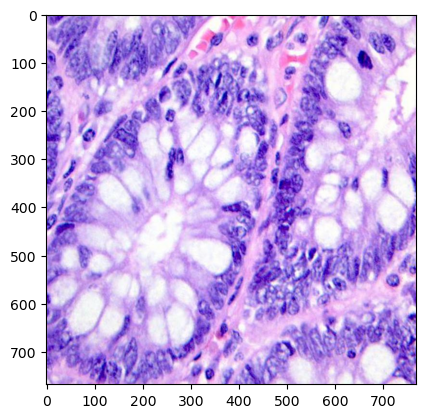

In [190]:
path_string = '/kaggle/working/dataset/test/colon_n/colonn4971.jpeg'
image = Image.open(path_string)
fig, ax = plt.subplots()
ax.imshow(image);

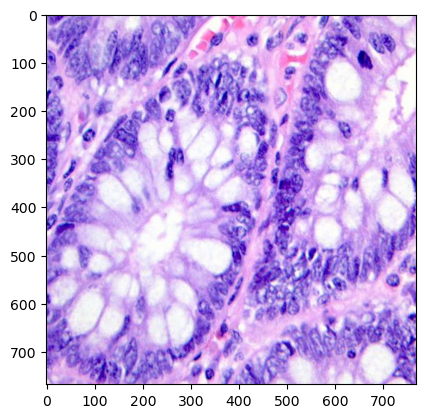

In [191]:
# Trying the process_image function

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
    
processed_image = process_image(path_string)
processed_image = processed_image.transpose((1,2,0))
processed_image = std * processed_image + mean
fig, ax = plt.subplots()
ax.imshow(processed_image);

#### Class Prediction

In [255]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image.
    '''
    
    with torch.no_grad():
        image = process_image(image_path)
        #print(image.shape)
        #print(image)
        image = torch.from_numpy(image)
        image.unsqueeze_(0)
        image = image.float()
        model,_,_ = load_checkpoint(model)
        #print(image.shape)
        #print(image)
        outputs = model(image)
        probabilities, indices = torch.exp(outputs).topk(topk)
        indices = np.array(indices)
        #print(indices)
        top_classes = [idx_to_class[x] for x in indices[0]]
        
        
        
        probabilities, classes = probabilities[0].tolist(), top_classes
        
        
        print("Class          Probability")
        for i in range(0, len(classes)):
            print(classes[i], "\t", round(probabilities[i],3))
        
        # Finding actual class
        if 'colon_n' in image_path[24:]:
            ground_truth = "colon_n"
        else:
            ground_truth = "colon_aca"
            
            
        image = Image.open(image_path)
        fig, ax = plt.subplots(2, 1, figsize=(3,7))
        
        y_positions = list(range(len(classes)))
    
        ax[1].barh(y_positions, probabilities)
        ax[1].set_yticks(y_positions)
        ax[1].set_yticklabels(classes)
        ax[1].set_xlabel('Probability of class (in %)')
        ax[1].invert_yaxis()
        ax[0].imshow(image)
    
        ax[0].set_title("Actual Class = {} ".format(ground_truth))
        
        
        
        prediction = classes[0]
        print("Predicted Class = {} ".format(prediction))
        if ground_truth == prediction:
            print("Correct Prediction!")
        else:
            print("Incorrect Prediction!" )
        
        

#### trying the predict function on training dataset...

In [206]:
# Extracting 10 random images from train directory

origin = '/kaggle/working/dataset/train/colon_n'

for root, dirs, files1 in os.walk(origin):
    continue
print("train/colon_n")
print(random.sample(files1, 10), end ='\n\n\n')

origin = '/kaggle/working/dataset/train/colon_aca'

for root, dirs, files2 in os.walk(origin):
    continue
print("train/colon_aca")
print(random.sample(files2, 10))

train/colon_n
['colonn2036.jpeg', 'colonn4482.jpeg', 'colonn4788.jpeg', 'colonn4087.jpeg', 'colonn2152.jpeg', 'colonn1625.jpeg', 'colonn4119.jpeg', 'colonn3359.jpeg', 'colonn1929.jpeg', 'colonn2337.jpeg']


train/colon_aca
['colonca2877.jpeg', 'colonca4381.jpeg', 'colonca1456.jpeg', 'colonca3267.jpeg', 'colonca70.jpeg', 'colonca1401.jpeg', 'colonca4159.jpeg', 'colonca1494.jpeg', 'colonca4167.jpeg', 'colonca4223.jpeg']


Class          Probability
colon_n 	 0.998
colon_aca 	 0.002
Predicted Class = colon_n 
Correct Prediction!


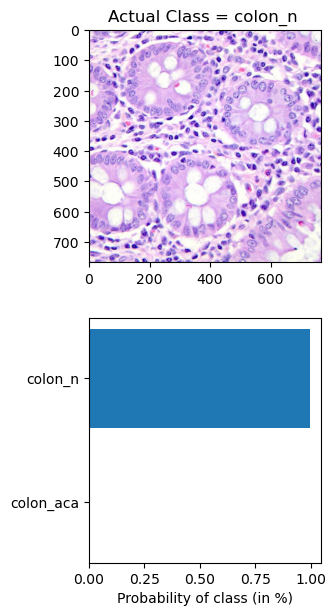

In [256]:
path_string = '/kaggle/working/dataset/train/colon_n/colonn4482.jpeg'
predict(path_string, 'checkpoint.pth')

Class          Probability
colon_aca 	 0.997
colon_n 	 0.003
Predicted Class = colon_aca 
Correct Prediction!


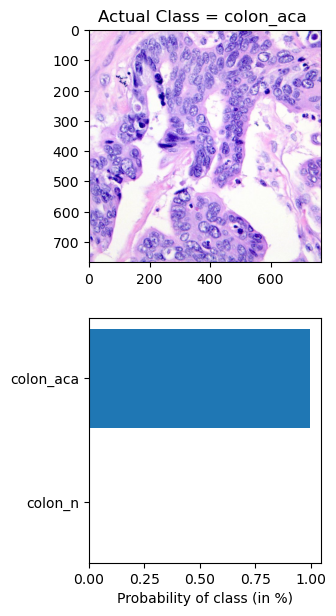

In [258]:
path_string = '/kaggle/working/dataset/train/colon_aca/colonca1456.jpeg'
predict(path_string, 'checkpoint.pth')

#### trying the predict function on test dataset...

In [212]:
# Extracting 10 random images from test directory

origin = '/kaggle/working/dataset/test/colon_n'

for root, dirs, files1 in os.walk(origin):
    continue
print("test/colon_n")
print(random.sample(files1, 10), end ='\n\n\n')

origin = '/kaggle/working/dataset/test/colon_aca'

for root, dirs, files2 in os.walk(origin):
    continue
print("test/colon_aca")
print(random.sample(files2, 10))

test/colon_n
['colonn110.jpeg', 'colonn2424.jpeg', 'colonn637.jpeg', 'colonn3351.jpeg', 'colonn3819.jpeg', 'colonn4467.jpeg', 'colonn422.jpeg', 'colonn1650.jpeg', 'colonn1895.jpeg', 'colonn109.jpeg']


test/colon_aca
['colonca267.jpeg', 'colonca1038.jpeg', 'colonca2006.jpeg', 'colonca1738.jpeg', 'colonca2015.jpeg', 'colonca1504.jpeg', 'colonca4373.jpeg', 'colonca3993.jpeg', 'colonca4947.jpeg', 'colonca3602.jpeg']


Class          Probability
colon_n 	 0.999
colon_aca 	 0.001
Predicted Class = colon_n 
Correct Prediction!


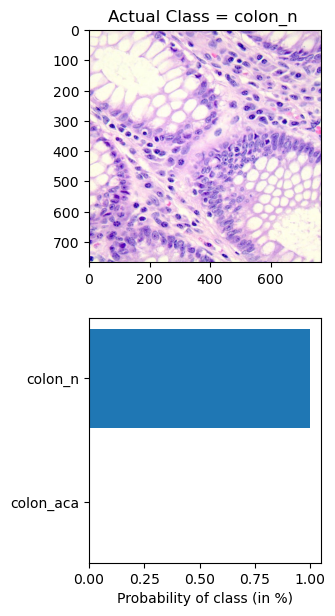

In [259]:
path_string = '/kaggle/working/dataset/test/colon_n/colonn637.jpeg'
predict(path_string, 'checkpoint.pth')

Class          Probability
colon_aca 	 0.701
colon_n 	 0.299
Predicted Class = colon_aca 
Correct Prediction!


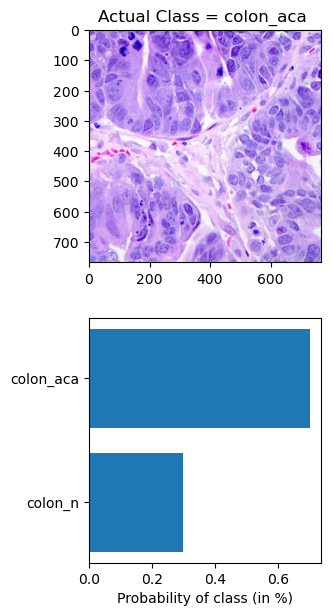

In [260]:
path_string = '/kaggle/working/dataset/test/colon_aca/colonca267.jpeg'
predict(path_string, 'checkpoint.pth')

Class          Probability
colon_aca 	 0.992
colon_n 	 0.008
Predicted Class = colon_aca 
Correct Prediction!


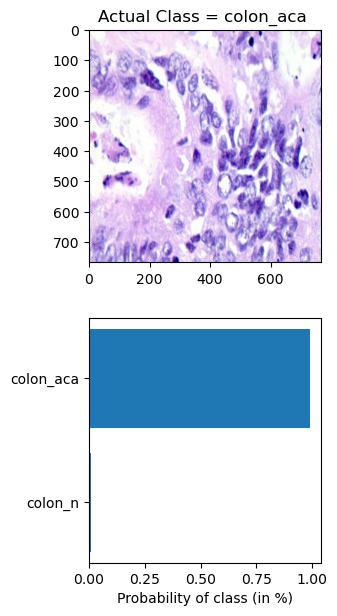

In [261]:
path_string = '/kaggle/working/dataset/test/colon_aca/colonca4947.jpeg'
predict(path_string, 'checkpoint.pth')